In [ ]:
import sys
sys.path.append('..')
sys.path.append('../Libraries/')
import pclpy
import Plane
import Corners
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd

Load cloud

In [ ]:
tic()
mm = pclpy.pcl.PointCloud.PointXYZRGB()
pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/downsampledcloud.pcd',mm)
#pclpy.pcl.io.loadPCDFile('fullCloudSFM.pcd',mm)
toc()

Load landmark cylindars

In [ ]:
position1 = np.array([-2.75,-6.,-22.8,0,0,1,0.2])
position2 = np.array([9.5,-34,-23.2,0,0,1,0.2])
position3 = np.array([24.5,6.5,-20.5,0,0,1,0.2])

cil1 = Corners.makecylinder(model=position1,length=3,dense=100)
PCCil = pclpy.pcl.PointCloud.PointXYZ(cil1)

cil2 = Corners.makecylinder(model=position2,length=3,dense=100)
PCCi2 = pclpy.pcl.PointCloud.PointXYZ(cil2)

cil3 = Corners.makecylinder(model=position3,length=3,dense=100)
PCCi3 = pclpy.pcl.PointCloud.PointXYZ(cil3)

if True:
    Corners.PCL3dpaint([mm,PCCil,PCCi2,PCCi3],axis=10)

In [4]:
Rvector10 = (position2[0:3]-position1[0:3])/np.linalg.norm(position2[0:3]-position1[0:3])
Rvector01 = (position3[0:3]-position1[0:3])/np.linalg.norm(position2[0:3]-position1[0:3])
REFpoints = np.vstack([[0,0,0],Rvector10,Rvector01])
NEWpoints = np.vstack([[0,0,0],[1,0,0],[0,1,0]])
Rot = Corners.SVDRigidBodyTransform(REFpoints,NEWpoints)[1]

Make transform from landmarks

In [5]:
tras1 = np.eye(4)
tras1[0:3,3] = -position1[0:3]
rotacion = Rot
traslacion = np.array([[0,0,0]]).T

tranformacion = np.hstack([rotacion,traslacion])
Htranformacion = np.vstack([tranformacion,[0,0,0,1]])
FullTrans = np.matmul(Htranformacion,tras1)

mmTrans = pclpy.pcl.PointCloud.PointXYZRGB()
pclpy.pcl.common.transformPointCloud(mm,mmTrans,FullTrans)
pclpy.pcl.common.transformPointCloud(PCCil,PCCil,FullTrans)
pclpy.pcl.common.transformPointCloud(PCCi2,PCCi2,FullTrans)

In [6]:
Svetor = FullTrans[0:4,0:4]@np.vstack([np.array([position2[0:3]]).T,1])
scale = 100/Svetor[0]
cil3 = Corners.makecylinder(model=[0, Svetor[0], 0,0,0,1,0.2],length=5,dense=100)
PCCi3 = pclpy.pcl.PointCloud.PointXYZ(cil3)
cil4 = Corners.makecylinder(model=[Svetor[0], Svetor[0], 0,0,0,1,0.2],length=5,dense=100)
PCCi4 = pclpy.pcl.PointCloud.PointXYZ(cil4)

In [7]:
rotacion = np.array([[1*scale,0,0],[0,1*scale,0],[0,0,1*scale]]).T
traslacion = np.array([[0,0,0]]).T
tranformacion = np.hstack([rotacion,traslacion])
Htranformacion = np.vstack([tranformacion,[0,0,0,1]])
FinalTrans = pclpy.pcl.PointCloud.PointXYZRGB()
pclpy.pcl.common.transformPointCloud(mmTrans,FinalTrans,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCil,PCCil,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi2,PCCi2,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi3,PCCi3,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi4,PCCi4,Htranformacion)

In [8]:
if True:
    Corners.PCL3dpaint([FinalTrans,PCCil,PCCi2,PCCi3,PCCi4])

Load data set trees

In [10]:
cil5 = Corners.makecylinder(model=[-10, 14.8, 1,0,0,1,0.4],length=5,dense=20) #0,0  -7.3,14
cil6 = Corners.makecylinder(model=[75, 15, -1,0,0,1,0.4],length=5,dense=20) #1,0 76.4,12.5
cil7 = Corners.makecylinder(model=[8.3, 95.4, 0,0,0,1,0.4],length=5,dense=20) #0,1  7.8,93.7
cil8 = Corners.makecylinder(model=[84.8, 70.5, -4.2,0,0,1,0.4],length=5,dense=20) #1,1  83.7,66.6

In [11]:
if True:
    Corners.PCL3dpaint([FinalTrans,cil5,cil6,cil7,cil8])

In [12]:
x0 = np.array([[-7.3,76.4,7.8,83.7]])
y0 = np.array([[14,12.5,93.7,66.6]])
z0 = np.zeros_like(x0)
ones = np.ones_like(x0)

x1 = np.array([[-10,75,8.3,84.8]])
y1 = np.array([[14.8,15,95.4,70.5]])
z1 = np.array([[1,-1,0,-4.2]])

In [13]:
if 'A' in dir():
    del A

for x,y,z,ox,oy,oz in np.vstack([x0,y0,z0,x1,y1,z1]).T:
    if 'A' in dir():
        A = np.vstack([A,np.array([[x,y,z,1,0,0,0,0,0,0,0,0],
                      [0,0,0,0,x,y,z,1,0,0,0,0],
                      [0,0,0,0,0,0,0,0,x,y,z,1]])])
        R = np.vstack([R,[[ox]
                      ,[oy]
                      ,[oz]]])
    else:
        A = np.array([[x,y,z,1,0,0,0,0,0,0,0,0],
                      [0,0,0,0,x,y,z,1,0,0,0,0],
                      [0,0,0,0,0,0,0,0,x,y,z,1]])
        R = np.array([[ox]
                      ,[oy]
                      ,[oz]])

In [14]:
coef = np.linalg.lstsq(A,R)[0].reshape(3,4)

C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [15]:
treedata = pd.read_excel('../../Data/NistClouds/NIST_2019_Survey.xlsx')
Xcoro,Ycoro,diam = treedata.iloc[0,[2,3,6]]
Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
surtreesL1o = [Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/100],length=10,dense=20)]
surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/100],length=10,dense=20)]
TreeDict = [{'Orig':treedata.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,Zcor])}]
for i,rows in treedata.iloc[1:].iterrows():
    Xcoro,Ycoro,diam = rows.iloc[[2,3,6]]
    Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1o.append(Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/200],length=10,dense=20))
        surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, Zcor,0,0,1,diam/200],length=10,dense=20))
        TreeDict.append({'Orig':rows.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,Zcor])})
surtrees1o = [p for i in surtreesL1o for p in i]
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

In [16]:
if True:
    Corners.PCL3dpaint([surtrees1o,FinalTrans])

In [17]:
if True:
    Corners.PCL3dpaint([surtrees1,FinalTrans])

Seperate ground and non ground

In [19]:
XYZ = FinalTrans.xyz
MinX, MinY, MaxX, MaxY = np.floor(np.min(XYZ[:,0],axis=0)), np.floor(np.min(XYZ[:,1],axis=0)), np.ceil(np.max(XYZ[:,0],axis=0)), np.ceil(np.max(XYZ[:,1],axis=0))

In [20]:
MinX, MinY, MaxX, MaxY = -10, -10, 110, 110

In [32]:
if False:
    #miniplot
    AllGround = []
    AllNonGround = []
    stepX = (MaxX-MinX)/8
    stepY = (MaxY-MinY)/8
    for nx,X in enumerate(np.arange(MinX,MaxX,stepX)):
        tic()
        for ny,Y in enumerate(np.arange(MinY,MaxY,stepY)):        
            ptfilter = pclpy.pcl.filters.CropBox.PointXYZRGB()
            ptfilter.setInputCloud(FinalTrans)
            ptfilter.setMin([X-2,Y-2,-40,0])
            ptfilter.setMax([X+stepX+2,Y+stepY+2,40,0])
            Cropedmm11 = pclpy.pcl.PointCloud.PointXYZRGB()
            ptfilter.filter(Cropedmm11)
            Nogroundpoints,ground = segTree.FloorRemove(Cropedmm11)
            AllGround.append(ground)
            AllNonGround.append(Nogroundpoints)

    FullNonGround = [p for i in AllNonGround for p in i.xyz]
    FullGround = [p for i in AllGround for p in i.xyz]

    NongroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullNonGround)
    GroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullGround)

    Corners.PCL3dpaint([NongroundCloud,GroundCloud])

    pclpy.pcl.io.savePCDFile('AllNonGround.pcd',NongroundCloud, binary_mode = True)
    pclpy.pcl.io.savePCDFile('AllGround.pcd',GroundCloud, binary_mode = True)

Encontrar arboles

In [33]:
NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
#pclpy.pcl.io.loadPCDFile('AllNonGround.pcd',NongroundCloud)
pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllNonGround.pcd',NongroundCloud)

0

In [36]:
tic()
goodpoints = segTree.RadiusOutlierRemoval(NongroundCloud.xyz, MinN=40, Radius=1.0, Organized=False)
toc()
tic()
cluster_list = segTree.EucladeanClusterExtract(goodpoints, tol=2.0, minc=30, maxc=250000)
toc()
ByClusters = []
tic()
for i in cluster_list:
    ppclusters = segTree.RegionGrowing(i, Ksearch=30, minc=30, maxc=100000, nn=30, smoothness=20.0, curvature=3.0)
    StemsinClusters = []
    for p in ppclusters:
        indices, model = segTree.segment_normals(p, searchRadius=30, model=pcl.SACMODEL_LINE, method=pcl.SAC_RANSAC, normalweight=0.0001, miter=2000, distance=1, rlim=[0,1])
        prop = len(indices)/len(p)

        if len(indices)>1 and prop>0.2 and np.arccos(np.dot([0,0,1],model[3:6]))<.8:
            points = p[indices]
            PC,_,_ = Plane.getPrincipalComponents(points)
            if PC[0]/PC[1]>10:
                StemsinClusters.append(points)
    if len(StemsinClusters) > 0:
        ByClusters.append(StemsinClusters)
toc()

254.97642010000004

In [37]:
allstemms = []
for i in ByClusters:
    for p in i:
        allstemms.append(p*1.03)

In [38]:
Corners.PCL3dpaint(allstemms+[FinalTrans])
Corners.PCL3dpaint(allstemms)

Conguntar troncos

In [39]:
composedtrees = []
components = []
GroupStems = []
for i in ByClusters:
    bufferStems = i.copy()
    for n,p in enumerate(bufferStems):
        samestems = [p]
        if len(bufferStems) > 1:
            for treenumber in reversed(range(n+1,len(bufferStems))):
                PC1 = Plane.getPrincipalComponents(p)
                PC2 = Plane.getPrincipalComponents(bufferStems[treenumber])
                center1 = PC1[2]
                center2 = PC2[2]
                angle1 = np.array(PC1[1][0])
                angle2 = np.array(PC2[1][0])
                if (Corners.DistPoint2Line(center1[0:3],angle2+center2[0:3],center2[0:3])<0.6) or (Corners.DistPoint2Line(center2[0:3],angle1+center1[0:3],center1[0:3])<0.6):
                    samestems.append(bufferStems[treenumber])
                    bufferStems.pop(treenumber)
        if len(samestems) > 1:
            GroupStems.append(np.array([p for i in samestems for p in i]))
        else:
            GroupStems.append(samestems[0])

In [40]:
Corners.PCL3dpaint(GroupStems+allstemms)

In [31]:
Corners.PCL3dpaint(GroupStems)

Troncos bajos

In [41]:
BigStems = [i for i in GroupStems if len(i) > 200]
lowStems = [i for i in BigStems if np.min(i,axis=0)[2] < 3]

In [33]:
if False:
    Corners.PCL3dpaint(BigStems+[np.array(surtrees1)],axis=10)

    Corners.PCL3dpaint(BigStems+lowStems,axis=10)

Corners.PCL3dpaint(lowStems)

Deteccion de cilindros

In [43]:
finalstems = []
stemcyls = []
for i in lowStems:
    PC,_,_ = Plane.getPrincipalComponents(i)
    if PC[0]/PC[1]>14:
        indices, model = segTree.segment_normals(i, searchRadius=20, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.0001, miter=8000, distance=0.06, rlim=[0,1])
        #Corners.PCL3dpaint([lowStems[Number],Corners.makecylinder(model=model,length=5,dense=20)])
        newmodel = model
        Z = 1
        Y = model[1] + model[4] * (Z - model[2]) / model[5]
        X = model[0] + model[3] * (Z - model[2]) / model[5]
        newmodel[0:3] = np.array([X,Y,Z])
        finalstems.append({'tree':i[indices],'model':model})
        stemcyls.append(Corners.makecylinder(model=newmodel,length=5,dense=20))

In [35]:
Corners.PCL3dpaint(stemcyls+[np.array(surtrees1)],axis=10)

In [40]:
Corners.PCL3dpaint(stemcyls+lowStems,axis=10)

In [37]:
matches = []
diametererror = []
cloudmatch = []
for n1,i in enumerate(finalstems):
    best=100
    number = -1
    for n2,p in enumerate(TreeDict):
        if np.linalg.norm(i['model'][0:2]-p['NewCoor'][0:2]) < best:
            number = n2
            best = np.linalg.norm(i['model'][0:2]-p['NewCoor'][0:2])
    matches.append(number)
    diametererror.append(abs(i['model'][6]*2-TreeDict[number]['Orig'][2]/100))
    cloudmatch.append(np.vstack([surtreesL1[number],i['tree'],stemcyls[n1]]))

In [44]:
treedata = pd.read_excel('../../Data/NistClouds/NIST_2019_Survey.xlsx')
Xcoro,Ycoro,diam = treedata.iloc[0,[2,3,6]]
Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
surtreesL1o = [Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/100],length=10,dense=20)]
surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/100],length=10,dense=20)]
TreeDict = [{'Orig':treedata.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,Zcor])}]
for i,rows in treedata.iloc[1:].iterrows():
    Xcoro,Ycoro,diam = rows.iloc[[2,3,6]]
    Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1o.append(Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/200],length=10,dense=20))
        surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, Zcor,0,0,1,diam/200],length=10,dense=20))
        TreeDict.append({'Orig':rows.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,diam/200])})
surtrees1o = [p for i in surtreesL1o for p in i]
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

In [46]:
from scipy.optimize import linear_sum_assignment

In [67]:
            #DataBase
#Found trees
#Hungarian Algorithm assignment
print('Hungarian Algorithm assignment :')
CostMat = np.ones([len(TreeDict),len(stemcyls)])
for X,datatree in enumerate(TreeDict):
    for Y,foundtree in enumerate(finalstems):
        CostMat[X,Y] = np.linalg.norm([datatree['NewCoor'][0:2]-foundtree['model'][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

#Get metrics
print('Get metrics: ')
locationerror = []
correctlocationerror = []
diametererror = []
cloudmatch = []
for i,j in zip(dataindex, foundindex):
    locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i]['NewCoor'][0:2])))
    if locationerror[-1]<2:
        diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i]['NewCoor'][2]))        
        correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i]['NewCoor'][0:2])))
    cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))

Hungarian Algorithm assignment :
Get metrics: 


In [57]:
Corners.PCL3dpaint(cloudmatch+[np.array(surtrees1)*1.01])

In [58]:
Corners.PCL3dpaint(cloudmatch)

In [68]:
import matplotlib.pyplot as plt

(array([15.,  8.,  8.,  5.,  2.,  1.,  1.,  1.,  0.,  1.]),
 array([0.04747225, 0.21185514, 0.37623804, 0.54062094, 0.70500383,
        0.86938673, 1.03376962, 1.19815252, 1.36253542, 1.52691831,
        1.69130121]),
 <a list of 10 Patch objects>)

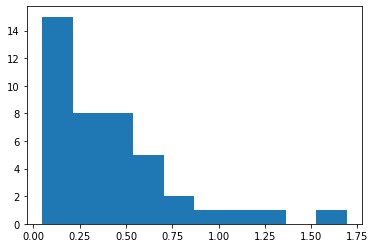

In [69]:
plt.hist(diametererror)

In [70]:
np.mean(np.array(diametererror)[np.array(diametererror)<0.5])

0.23083688949305434

In [71]:
np.mean(np.array(diametererror))

0.41372052976914814

In [72]:
len(np.array(diametererror)[np.array(diametererror)<0.5]),len(diametererror)

(29, 42)

In [73]:
len(TreeDict)

337